In [2]:
# Imports
import datetime
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import requests
import shutil
from sklearn.linear_model import LinearRegression

# 3.1. Stations-IDs

In [3]:
# Klasse, in der die Informationen für jede Station gespeichert werden
class Station():
    def __init__(self, name, id):
        self.name = name
        self.id = id
        self.hist_data = None
        self.pred_data = None
        self.weather_variability = None

    def get_hist_data(self):
        return self.hist_data

    def set_hist_data(self, hist_data):
        self.hist_data = hist_data
        # 4.1. Berechnen der Wetter-Variabilität
        # Berechne die Wetterveränderung, sobald die nötigen Daten vorliegen
        self.calculate_weather_variability()

    def get_weather_variability(self):
        return self.weather_variability

    # 4.1. Berechnen der Wetter-Variabilität
    # Methode zum Berechnen der Wetter-Variabilität des Standorts. Hierzu wird die Spannweite der drei betrachteten
    # Messwerte berechnet. Aus diesen drei Werten wird anschließend der Durchschnitt gebildet. Dieser Wert soll
    # zur Betrachtung der Wetter-Variabilität verwendet werden.
    def calculate_weather_variability(self):
        tmk_range = self.hist_data['TMK'].max() - self.hist_data['TMK'].min()
        sdk_range = self.hist_data['SDK'].max() - self.hist_data['SDK'].min()
        rsk_range = self.hist_data['RSK'].max() - self.hist_data['SDK'].min()
        self.weather_variability = (tmk_range + sdk_range + rsk_range) / 3

In [4]:
# Abrufen der Liste aller verfügbaren Stationen vom Webserver des DWD. Diese Liste wird später nach den IDs
# der zu prüfenden Stationen durchsucht.
url = 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/kl/historical/KL_Tageswerte_Beschreibung_Stationen.txt'
all_stations = requests.get(url).text
# Teile den HTML-Quelltext nach neuen Zeilen auf
all_stations = all_stations.split('\r\n')

In [5]:
# 10 Städte, die in der Analyse betrachtet werden sollen
# Die Städte wurden manuell ausgewählt. Zunächst wurden die Orte anhand der Liste von deutschen Großstädten
# ausgewählt. Anschließend wurde geprüft, ob es beim DWD aktuelle Daten für die Städte gibt und ein dort
# vorhandener Sensor gewählt 
locations = ['Berlin Brandenburg',
             'Dresden-Klotzsche',
             'München-Stadt',
             'Köln/Bonn',
             'Frankfurt/Main',
             'Stuttgart-Echterdingen',
             'Düsseldorf',
             'Leipzig/Halle',
             'Bremen',
             'Essen-Bredeney']

# Für die zehn Orte, die genauere analysiert werden sollen, wird die Stations-ID aus der Liste alle
# Stationen extrahiert. Die zehn Stationen werden mit Namen und ID in der Liste "stations" gespeichert

stations = []
for location in locations:
    station_entry = list(filter(lambda x: location in x, all_stations))
    id = station_entry[0][0:5]
    stations.append(Station(location, id))

# 3.2. Historische Daten

In [6]:
# Die Wetterdaten für jede der zu prüfenden Stationen liegen im ZIP-Dateiformat auf dem Server der DWD vor.
# Da die Dateinamen nicht immer mit dem Start- und Enddatum der Aufzeichung, welche in der Liste aller
# Stationen oben theoretisch enthalten wären, übereinstimmen, wird der Dateiname anhand der Stations-ID und
# einer RegEx Expression ermittelt und die ZIP-Datei mit den historischen Wetterdaten heruntergeladen. 
# Nachdem die Daten heruntergeladen wurden, werden die ZIP-Dateien entpackt dem jeweiligen Stations-Objekt
# hinzugefügt. Dabei werden die Daten bereinigt.

# Abrufen des HTML-Quelltext des DWD-Servers. Hieraus können die von uns benötigten Dateinamen ermittelt werden
base_url = 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/kl/historical/'
response = requests.get(base_url)

for station in stations:
    # Durchsuchen des HTML-Quelltext nach den Dateien, welche die Wetterdaten für die gewählten Stationen
    # enthalten. Dabei wird eine Rexex-Expression verwendet.
    regex = '(tageswerte_KL_' + station.id + ').*?(_hist.zip)'
    match_result = re.search(rf'{regex}', str(response.content))
    filename = str(response.content)[match_result.start():match_result.end()]
    
    # Abrufen, speichern und Entpackend der ZIP-Datei
    url = base_url + filename
    r = requests.get(url)
    open(filename, 'wb').write(r.content)
    shutil.unpack_archive(filename, filename[:-4])

    # Den Dateinamen der historischen Daten in dem entpackten Ordner ermitteln
    data_file_name = glob.glob(f'{filename[:-4]}/produkt_klima_tag*')[0]
    # Einlesen in einen Dataframe
    df = pd.read_csv(data_file_name, delimiter=';')
    # Bereinigen der Header
    df.columns = df.columns.str.strip()
    # Auswählen der benötigten Spalten
    df = (df[['MESS_DATUM', 'TMK', 'SDK', 'RSK']])
    # Einschränken des ausgwählten Datum. Die Messdaten werden alle bis zum 31.12.2022 ausgegeben, deshalb
    # wird als ältester Messwert der 31.12.2012 gewählt
    df = df[df.MESS_DATUM >= 20121231]
    # Falls es leere Werte gibt, werden diese mit den Durchschnittswerten der jeweiligen Spalten gefüllt
    df['TMK'].fillna((df['TMK'].mean()), inplace=True)
    df['SDK'].fillna((df['SDK'].mean()), inplace=True)
    df['RSK'].fillna((df['RSK'].mean()), inplace=True)
    # Falsche Messwerte beim DWD werden auch mit -999 befüllt. Diese Werte werden auch mit den Durchschnittswerten
    # der jeweiligen Spalten gefüllt
    df['TMK'].replace(-999, df['TMK'].mean(), inplace=True)
    df['SDK'].replace(-999, df['SDK'].mean(), inplace=True)
    df['RSK'].replace(-999, df['RSK'].mean(), inplace=True)
    # Umwandeln des Messdatums-Wert in ein Datetime-Objekt zur späteren weiterverarbeitung
    df['MESS_DATUM'] = pd.to_datetime(df['MESS_DATUM'], format='%Y%m%d')
    # Zurücksetzen des Index. Da oben nur Zeilen nach dem 31.12.2012 ausgewählt wurden, würde der Index auch
    # erst mit diesen Zeilen beginnen. Damit dieser wieder bei 0 beginnt, wird der Index hier zurückgesetzt
    df.reset_index(drop=True, inplace=True)
    # Speichern der historischen Wetterdaten in dem zugehörigen Objekt
    station.set_hist_data(df)

# 4.2. Darstellen der Wetter-Variabilität

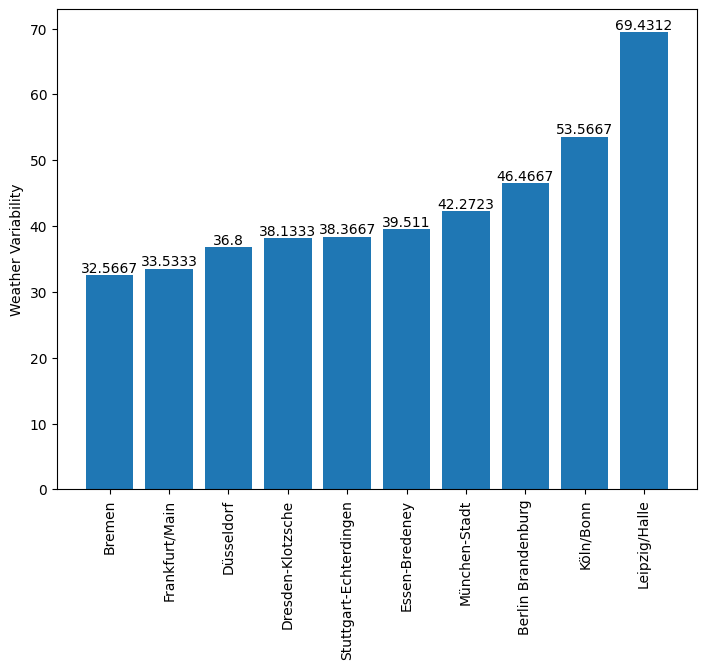

In [7]:
# Plot für die Wetter-Variabilität, welche zuvor berechnet wird. Es wird ein sortierter Barplot generiert, anhand
# dessen ersichtlich ist, wie hoch die berechnete Wetter-Variabilität pro Standort ist.

# Listen für die X und Y Daten im Plot
names = []
weather_variability = []

for station in stations:
    # Befüllen der Listen für X und Y Daten
    names.append(station.name)
    weather_variability.append(station.get_weather_variability())

# Plotten der Daten
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
# Sortieren der Daten anhand der Wetter-Variabilität
y,x = (zip(*sorted(zip(weather_variability, names))))
# Erstellen der Säulen
bars = ax.bar(x,y)
# Beschriftung der Y-Achse
ax.set_ylabel('Weather Variability')
# Rotieren der Beschriftung auf der Y-Achse
ax.tick_params(axis='x', labelrotation=90)
# Einfügen der Beschriftung der Säulen
ax.bar_label(bars)
plt.show()

# 5.1. Berechnen der Vorhersage

In [8]:
# Für den besten Standort sollen nun die Wetterdaten für die nächsten drei Jahre mittels Linearer Regression
# vorhergesagt werden. Deshalb muss zunächst der Ort mit der geringsten Variabilität ermittelt werden.
# Da die Stationsnamen bereits im vorhergehenden Schritt zur Plot-Erstellung sortiert wurden, kann gleich
# auf die Daten zugrückgegriffen werden
for station in stations:
    if station.name == x[0]:
        station_with_lowest_variability = station
        break

In [9]:
# Für den Standort mit der geringsten Wetter-Variabilität soll nun für die Wetterdaten jeweils eine lineare
# Regression durchgeführt werden

# Extrahieren der Jahres-, Monats- und Tageszahlen, damit diese für die Lineare Regression verwendet werden können
hist_data = station_with_lowest_variability.get_hist_data()
hist_data['YEAR'] = hist_data['MESS_DATUM'].dt.year
hist_data['MONTH'] = hist_data['MESS_DATUM'].dt.month
hist_data['DAY'] = hist_data['MESS_DATUM'].dt.day

X = hist_data[['YEAR', 'MONTH', 'DAY']]

# Erstellen von drei Regressions-Modellen, jeweils ein Modell für einen Wetter-Parameter, welcher
# vorhergesagt werden soll
y = hist_data['TMK']
regression_TMK = LinearRegression().fit(X, y)

y = hist_data['SDK']
regression_SDK = LinearRegression().fit(X, y)

y = hist_data['RSK']
regression_RSK = LinearRegression().fit(X, y)

In [10]:
# Nachdem jeweils ein Regressions-Modell für die drei Wetter-Parameter erstellt wurde, müssen nun die
# Zukunfts-Daten vorhergesagt werden
# Zunächst wird hierzu ein neuer Dateframe mit Daten in der Zukunft vorbereitet, welcher dann mit den
# Ergebnissen befüllt werden kann
start_date = '2024-01-01'
end_date = '2026-12-31'

# Erstellen des Dataframes und extrahieren der Jahres-, Monats- und Tageszahlen
date_series = pd.date_range(start=start_date, end=end_date, freq='D')
df_pred = pd.DataFrame({'MESS_DATUM': date_series})
df_pred['YEAR'] = df_pred['MESS_DATUM'].dt.year
df_pred['MONTH'] = df_pred['MESS_DATUM'].dt.month
df_pred['DAY'] = df_pred['MESS_DATUM'].dt.day

# Nachdem der Dataframe für die vorhergesagten Daten vorbereitet wurde, können nun die Wetter-Daten
# vorhergesagt und in dem Dataframe gespeichert werden
X = df_pred[['YEAR', 'MONTH', 'DAY']]
df_pred['TMK'] = regression_TMK.predict(X)
df_pred['SDK'] = regression_SDK.predict(X)
df_pred['RSK'] = regression_RSK.predict(X)
df_pred.head()

,MESS_DATUM,YEAR,MONTH,DAY,TMK,SDK,RSK
0,2024-01-01,2024,1,1,8.256595,5.955516,1.338825
1,2024-01-02,2024,1,2,8.270284,5.952290,1.348288
2,2024-01-03,2024,1,3,8.283973,5.949064,1.357752
3,2024-01-04,2024,1,4,8.297663,5.945838,1.367215
4,2024-01-05,2024,1,5,8.311352,5.942612,1.376678


# 5.2. Darstellen der Vorhersage

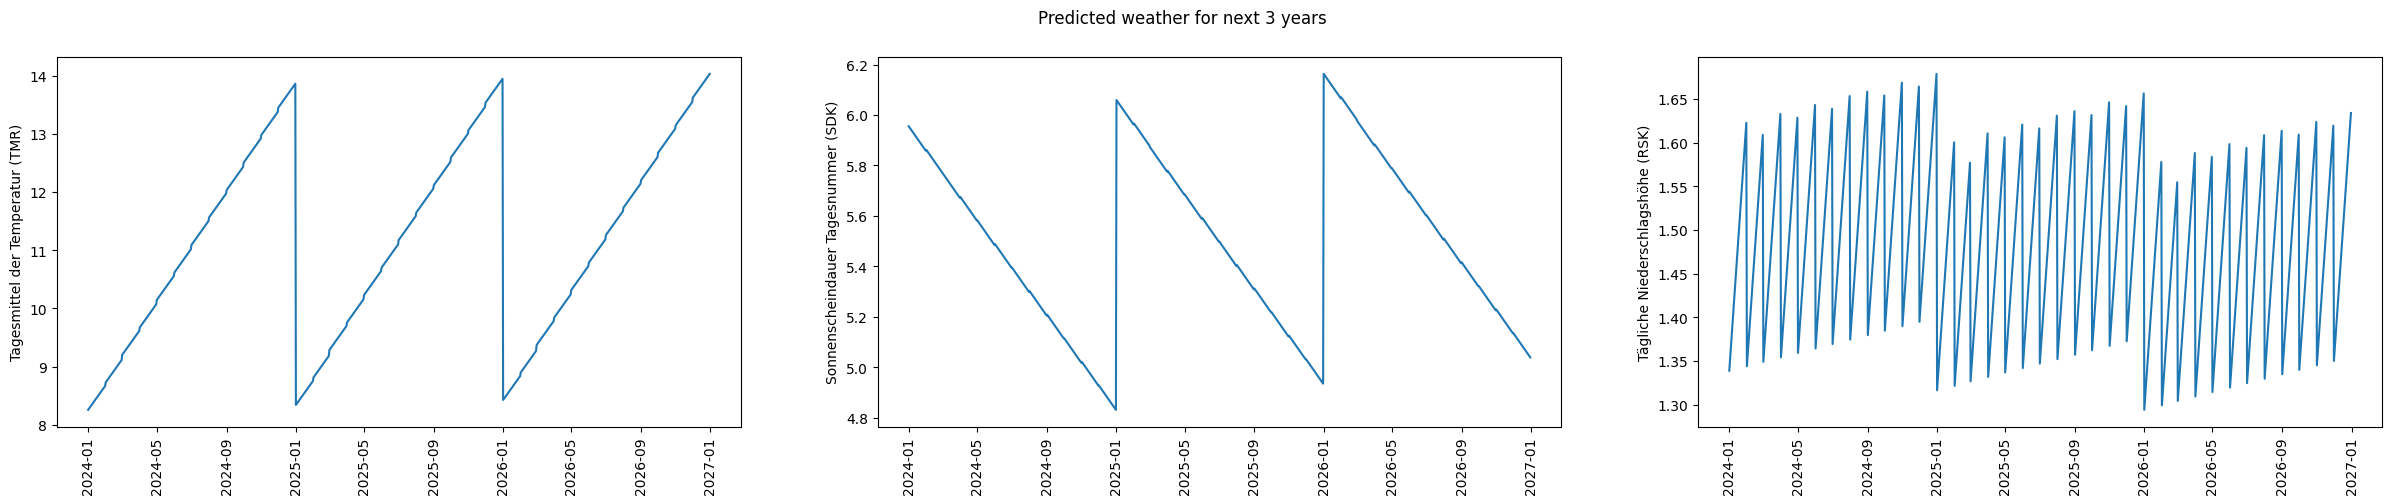

In [11]:
# Die vorhergesagten Daten sollen abschließend noch in Form eines Plots dargestellt werden.
x = df_pred['MESS_DATUM']

# Zur Datstellung wird ein Plot mit drei Subplots verwendet. Jeweils ein Wetter-Parameter soll in einem
# Subplot dargestellt werden.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(30)
fig.suptitle('Predicted weather for next 3 years')

ax1.plot(x,df_pred['TMK'])
ax1.set_ylabel('Tagesmittel der Temperatur (TMR)')
ax1.tick_params(axis='x', labelrotation=90)

ax2.plot(x,df_pred['SDK'])
ax2.set_ylabel('Sonnenscheindauer Tagesnummer (SDK)')
ax2.tick_params(axis='x', labelrotation=90)

ax3.plot(x,df_pred['RSK'])
ax3.set_ylabel('Tägliche Niederschlagshöhe (RSK)')
ax3.tick_params(axis='x', labelrotation=90)
plt.show()